
## A Gentle Introduction to use Auto Encoders for Anomaly Detection
#### Author Nagdev Amruthnath
Date: 1/9/2019

#### Citation Info
If you are using this for your research, please use the following for citation.

Amruthnath, Nagdev, and Tarun Gupta. "A research study on unsupervised machine learning algorithms for early fault detection in predictive maintenance." In 2018 5th International Conference on Industrial Engineering and Applications (ICIEA), pp. 355-361. IEEE, 2018.

#### Disclaimer
This is a tutorial for performing fault detection using machine learning. You this code at your own risk. I do not gurantee that this would work as shown below. If you have any suggestions please branch this project.

### Load Libraries

In [31]:
options(warn=-1)

# load libraries
library(dplyr)
library(h2o)


### Load data
Here we are using data from a bench press. There are total of four different states in this machine and they are split into four different csv files. We need to load the data first. In the data time represents the time between samples, ax is the acceleration on x axis, ay is the acceleration on y axis, az is the acceleration on z axis and at is the G's. The data was collected at sample rate of 100hz.

Four different states of the machine were collected

    1. Nothing attached to drill press
    2. Wooden base attached to drill press
    3. Imbalance created by adding weight to one end of wooden base
    4. Imbalacne created by adding weight to two ends of wooden base.

In [32]:
setwd("/home/")
#read csv files
file1 = read.csv("dry run.csv", sep=",", header =T)
file2 = read.csv("base.csv", sep=",", header =T)
file3 = read.csv("imbalance 1.csv", sep=",", header =T)
file4 = read.csv("imbalance 2.csv", sep=",", header =T)
head(file1)

time,ax,ay,az,aT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.002,-0.3246,0.2748,0.1502,0.451
0.009,0.6020,-0.1900,-0.3227,0.709
0.019,0.9787,0.3258,0.0124,1.032
0.027,0.6141,-0.4179,0.0471,0.744
0.038,-0.3218,-0.6389,-0.4259,0.833
0.047,-0.3607,0.1332,-0.1291,0.406


We can look at the summary of each file using summary function in R. Below, we can observe that 66 seconds long data is available. We also have min, max and mean for each of the variables.

In [33]:
# summary of each file
summary(file2)

      time               ax                  ay                  az          
 Min.   :  0.004   Min.   :-1.402700   Min.   :-1.693300   Min.   :-3.18930  
 1st Qu.: 27.005   1st Qu.:-0.311100   1st Qu.:-0.429600   1st Qu.:-0.57337  
 Median : 54.142   Median : 0.015100   Median :-0.010700   Median :-0.11835  
 Mean   : 54.086   Mean   : 0.005385   Mean   :-0.002534   Mean   :-0.09105  
 3rd Qu.: 81.146   3rd Qu.: 0.314800   3rd Qu.: 0.419475   3rd Qu.: 0.34815  
 Max.   :108.127   Max.   : 1.771900   Max.   : 1.515600   Max.   : 5.04610  
       aT        
 Min.   :0.0360  
 1st Qu.:0.6270  
 Median :0.8670  
 Mean   :0.9261  
 3rd Qu.:1.1550  
 Max.   :5.2950  

### Data Aggregration and feature extraction
Here, the data is aggregated by 1 minute and features are extracted. Features are extracted to reduce the dimension of the data and only storing the representation of the data.

In [34]:
file1$group = as.factor(round(file1$time))
file2$group = as.factor(round(file2$time))
file3$group = as.factor(round(file3$time))
file4$group = as.factor(round(file4$time))
#(file1,20)

#list of all files
files = list(file1, file2, file3, file4)

#loop through all files and combine
features = NULL
for (i in 1:4){
res = files[[i]] %>%
    group_by(group) %>%
    summarize(ax_mean = mean(ax),
              ax_sd = sd(ax),
              ax_min = min(ax),
              ax_max = max(ax),
              ax_median = median(ax),
              ay_mean = mean(ay),
              ay_sd = sd(ay),
              ay_min = min(ay),
              ay_may = max(ay),
              ay_median = median(ay),
              az_mean = mean(az),
              az_sd = sd(az),
              az_min = min(az),
              az_maz = max(az),
              az_median = median(az),
              aT_mean = mean(aT),
              aT_sd = sd(aT),
              aT_min = min(aT),
              aT_maT = max(aT),
              aT_median = median(aT)
             )
    features = rbind(features, res)
}

#view all features
head(features)

group,ax_mean,ax_sd,ax_min,ax_max,ax_median,ay_mean,ay_sd,ay_min,ay_may,⋯,az_mean,az_sd,az_min,az_maz,az_median,aT_mean,aT_sd,aT_min,aT_maT,aT_median
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-0.038164706,0.6594686,-1.2587,1.3821,-0.0955,-0.0682627451,0.7506785,-1.3892,1.6418,⋯,-0.13803333,0.9845115,-2.6753,2.7507,0.0254,1.273216,0.5830149,0.400,3.029,1.0770
1,-0.005806122,0.6325808,-1.6194,1.1943,-0.0015,0.0037908163,0.7819044,-1.5625,1.5428,⋯,-0.20496837,0.9252188,-3.0774,2.7158,-0.2121,1.263622,0.5448447,0.410,3.197,1.1375
2,0.069845455,0.6665500,-1.4554,1.4667,0.1070,0.0744333333,0.8022922,-1.4800,1.7951,⋯,-0.06405354,0.9293866,-1.8205,2.4862,-0.1512,1.298364,0.5131552,0.255,2.644,1.2830
3,0.011552525,0.5511310,-1.9254,1.2034,0.0675,0.0008262626,0.7894209,-2.0042,1.5577,⋯,-0.09287879,0.8893505,-2.1562,3.2355,-0.1672,1.203848,0.5125826,0.393,3.322,1.1180
4,0.046688119,0.6426574,-1.7805,1.4837,0.0836,-0.0177594059,0.7510811,-1.6629,1.4369,⋯,-0.13990000,0.9265720,-1.8515,3.5451,-0.1741,1.226267,0.5824608,0.313,3.597,1.1720
5,0.006678788,0.5780957,-1.4719,1.4355,0.0536,0.0013626263,0.7812245,-1.6293,1.6362,⋯,-0.16540000,0.9091516,-2.5561,2.9196,-0.2588,1.209515,0.5664847,0.336,3.035,1.1590


### Create Train and Test Set
To build an anomaly detection model, a train and test set is required. Here, the normal condition of the data is used for training and remaining is used for testing.

In [35]:
# create train and test set
train = features[1:67,2:ncol(features)]
test = features[68:nrow(features),2:ncol(features)]

### Auto Encoders
Autoencoders is an unsupervised version of neural network that is used for data encoding. This technique is mainly used to learn the representation of data that can be used for dimensionality reduction by training network to ignore noise. Autoencoders play an important role in unsupervised learning and deep architectures mainly for transfer learning (Pierre. B, 2012). When autoencoders are decoded, they are simple linear circuits that transforms inputs to outputs with least distortion. Autoencoders were first introduced in 1980’s to address the issue of back propagation without training and rather use input as a teacher (Rumelhart et al., 1986). Since then, autoencoders have taken a phase change to the form on Restricted Boltzman Machine. Today, autoencoders are used in various applications such as predicting sentiment distributions in Natural Language Processing (NLP) (Socher et al., 2011a) (Socher et al., 2011b), feature extraction (Masci et al., 2011), anomaly detection (Sakurada et al., 2014), facial recognition (Gao et al., 2015), clustering (Dilokthanakul et al., 2016), image classification (Geng et al., 2015) and many other application. 

#### Auto Encoders using H2O package
Use the h2o.init() method to initialize H2O. This method accepts the following options. Note that in most cases, simply using h2o.init() is all that a user is required to do.

In [36]:
# initialize h2o cluser
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         51 minutes 33 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.2 
    H2O cluster version age:    3 months and 3 days  
    H2O cluster name:           H2O_started_from_R_root_ufj371 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   28.95 GB 
    H2O cluster total cores:    1 
    H2O cluster allowed cores:  1 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.3.3 (2017-03-06) 



The R object to be converted to an H2O object should be named so that it can be used in subsequent analysis. Also note that the R object is converted to a parsed H2O data object, and will be treated as a data frame by H2O in subsequent analysis.

In [37]:
# convert train and test to h2o object
train_h2o = as.h2o(train)
test_h2o = as.h2o(test)

  |======================================================================| 100%
  |======================================================================| 100%


The h2o.deeplearning function fits H2O's Deep Learning models from within R. While H2O Deep Learning has many parameters, it was designed to be just as easy to use as the other supervised training methods in H2O. Early stopping, automatic data standardization and handling of categorical variables and missing values and adaptive learning rates (per weight) reduce the amount of parameters the user has to specify. Often, it's just the number and sizes of hidden layers, the number of epochs and the activation function and maybe some regularization techniques.

In [38]:
# build auto encoder model with 3 layers
model_unsup = h2o.deeplearning(x = 2:ncol(features)
                 , training_frame = train_h2o
                 , model_id = "Test01"
                 , autoencoder = TRUE
                 , reproducible = TRUE
                 , ignore_const_cols = FALSE
                 , seed = 42
                 , hidden = c(50,10,50,100,100)
                 , epochs = 100
                 , activation ="Tanh")



  |======================================================================| 100%


In [39]:
# view the model
model_unsup

Model Details:

H2OAutoEncoderModel: deeplearning
Model ID:  Test01 
Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 19,179 weights/biases, 236.0 KB, 2,546 training samples, mini-batch size 1
  layer units  type dropout       l1       l2 mean_rate rate_rms momentum
1     1    19 Input  0.00 %       NA       NA        NA       NA       NA
2     2    50  Tanh  0.00 % 0.000000 0.000000  0.029104 0.007101 0.000000
3     3    10  Tanh  0.00 % 0.000000 0.000000  0.021010 0.006320 0.000000
4     4    50  Tanh  0.00 % 0.000000 0.000000  0.024570 0.006848 0.000000
5     5   100  Tanh  0.00 % 0.000000 0.000000  0.052482 0.018357 0.000000
6     6   100  Tanh  0.00 % 0.000000 0.000000  0.052677 0.021417 0.000000
7     7    19  Tanh      NA 0.000000 0.000000  0.025557 0.009494 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0.000069   0.180678  0.001542 0.017311
3    0.000008   0.187546 -0.000435 0.011542
4    0.011

Detect anomalies in an H2O dataset using an H2O deep learning model with auto-encoding trained previously.

In [40]:
# now we need to calculate MSE or anomaly score  
anmlt = h2o.anomaly(model_unsup
                      , train_h2o
                      , per_feature = FALSE) %>% as.data.frame()
# create a label for healthy data
anmlt$y = 0

# view top data
head(anmlt)

Reconstruction.MSE,y
<dbl>,<dbl>
0.001953387,0
0.004875430,0
0.002195593,0
0.006722837,0
0.001670331,0
0.005859846,0


Calulate the threshold value for train anomaly scores. Various methods can be used such as calculating the quantiles, max, median, min etc. It all depends on the use case. Here we will use quantile with probability of 99.9%. 

In [41]:
# calculate thresholds from train data
threshold = quantile(anmlt$Reconstruction.MSE, probs = 0.999)

Now, we have anomaly score for train and its thresholds, we can predict the new anomaly scores for test data and plot it to see how it differs from train data. 

In [42]:
# calculate anomaly scores for test data
test_anmlt = h2o.anomaly(model_unsup
                      , test_h2o
                      , per_feature = FALSE) %>% as.data.frame()

# create a label for healthy data
test_anmlt$y = 1

In [43]:
# combine the train and test anomaly scores for visulaizatio
results = data.frame(rbind(anmlt,test_anmlt), threshold)
head(results)

Reconstruction.MSE,y,threshold
<dbl>,<dbl>,<dbl>
0.001953387,0,0.01705935
0.004875430,0,0.01705935
0.002195593,0,0.01705935
0.006722837,0,0.01705935
0.001670331,0,0.01705935
0.005859846,0,0.01705935


The results are plotted below. The x axis is the observations and y axis is the anomaly score. The green points are the trained data and red are test data. We can note that all the data that was trained except one lied below the anomaly limit. Its also interesting to note the increasing trend pattern for the anomaly scores for other state of the machine. 

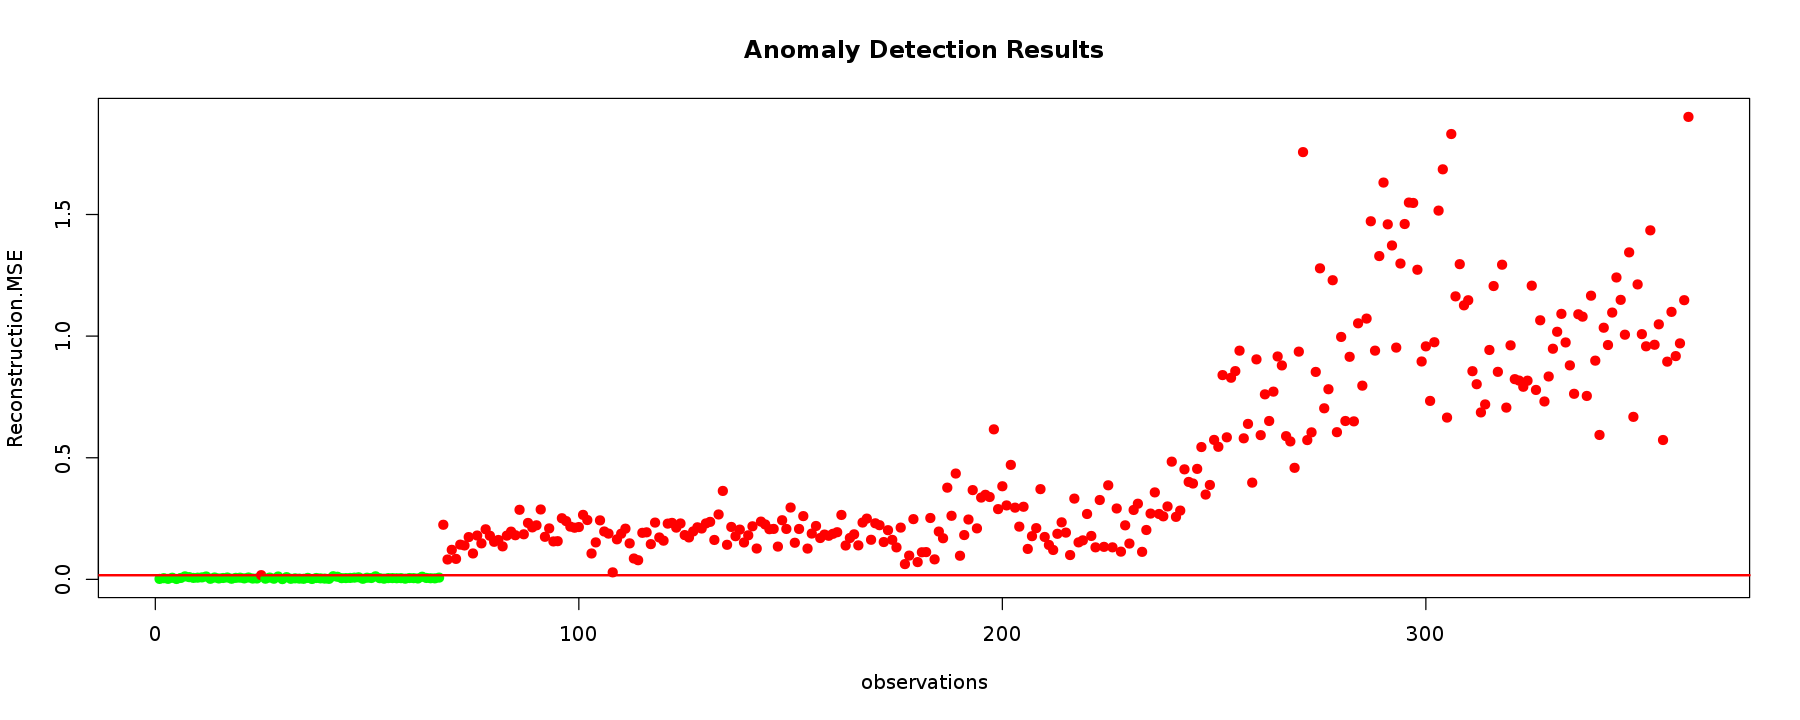

In [44]:
# Adjust plot sizes
options(repr.plot.width = 15, repr.plot.height = 6)
plot(results$Reconstruction.MSE, type = 'n', xlab='observations', ylab='Reconstruction.MSE', main = "Anomaly Detection Results")
points(results$Reconstruction.MSE, pch=19, col=ifelse(results$Reconstruction.MSE < threshold, "green", "red"))
abline(h=threshold, col='red', lwd=2)

### Session info
Below is the session info for the the packages and their versions used in this analysis. 

In [45]:
sessionInfo()

R version 3.3.3 (2017-03-06)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 9 (stretch)

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] h2o_3.26.0.2 dplyr_0.8.3 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.2          magrittr_1.5        tidyselect_0.2.5   
 [4] uuid_0.1-2          R6_2.4.0            rlang_0.4.0        
 [7] tools_3.3.3         htmltools_0.3.6     assertthat_0.2.1   
[10] digest_0.6.20       tibble_2.1.3        crayon_1.3.4       
[13] IRdisplay_0.7.0     purrr_0.3.2         repr_1.0.1         
[16] base64enc_0.1-3     vctrs_0.2.0         bitops_1.0-6  